# 4_Plume_Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plume_learn.plume_utils.viz import show_images, label_violinplot
from plume_learn.plume_utils.manage_plume import remove_all_0_plume, load_json
from plume_learn.plume_analyzer.PlumeDataset import plume_dataset
from m3util.viz.layout import layout_fig
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines
from sro_sto_plume.modify_df import modify_df
from sro_sto_plume.packed_plot_functions import plot_temporal_violins, plot_temporal_heatmaps
from matplotlib import colormaps
colors = colormaps.get_cmap('tab10').colors[:6]

from m3util.viz.printing import printer
printing = printer(basepath = '../figures/', fileformats=['png', 'svg', 'tif'], dpi=600)

## 1. Load Plume data

### 1.1 load experiment conditions

In [16]:
sample_names = ['t1', 't2', 't3', 't4', 't5/s1']
sample_ids = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069']
plume_recording_root = '../data/Plumes/plume_recordings/'
output_root = '../data/Plumes/plume_metrics/'

### 1.2 load metrics for every plume frame

In [17]:
df_frame_metrics = []
for id, growth_name in zip(sample_ids, sample_names):
    file = glob.glob(f'{output_root}/{id}*metrics.csv')[0]
    df = pd.read_csv(file)
    df_processed = modify_df(df)
    df_frame_metrics.append(df_processed)
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics

C:\Users\yig319\AppData\Local\Temp\ipykernel_5940\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_5940\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_5940\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_5940\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_5940\3963947821.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Plume Index,Time (µs),Distance (m),Velocity (m/s),Area (a.u.),Threshold,Sample Name,Sample ID
0,0,0.0,0.000000,0.000000,0.0,200,t1,YG065
1,0,0.5,0.000000,0.000000,0.0,200,t1,YG065
2,0,1.0,0.008715,17429.394813,2074.0,200,t1,YG065
3,0,1.5,0.014784,12138.328530,3144.0,200,t1,YG065
4,0,2.0,0.021476,13383.285303,9039.0,200,t1,YG065
...,...,...,...,...,...,...,...,...
232827,287,61.5,0.032680,0.000000,0.0,200,t5/s1,YG069
232828,287,62.0,0.032680,0.000000,0.0,200,t5/s1,YG069
232829,287,62.5,0.032680,0.000000,0.0,200,t5/s1,YG069
232830,287,63.0,0.032680,0.000000,0.0,200,t5/s1,YG069


### 1.3 calculate max area and incident velocity

In [18]:
# analyze the max area
idx = df_frame_metrics.groupby(['Sample Name', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Sample Name', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)

# analyze plume Velocity that can be tracked before landing on the substrate
## calculate the velocity between 2.8cm and 2.9cm for the incident velocity
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 0.029) & (df_frame_metrics['Distance (m)'] <= 0.030)] 
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Sample Name', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Sample Name', 'Plume Index'])
df_plume_metrics.sample(5)

,Sample Name,Plume Index,Time at Max Area (µs),Max Area (a.u.),Incident Velocity (m/s)
275,t2,159,3.0,14293.0,3423.631124
248,t2,113,3.0,16212.0,4979.827089
271,t2,145,3.0,14903.0,4357.348703
797,t5/s1,173,3.0,16008.0,5291.066282
320,t2,239,3.0,15797.0,5291.066282


## 2. Introduction to Plume Dynamics Analysis

### 2.1 Violin Plot of Plume Max Area and Incident Velocity Statics

../figures/5-Plume_metrics_violinplot.png
../figures/5-Plume_metrics_violinplot.svg
../figures/5-Plume_metrics_violinplot.tif


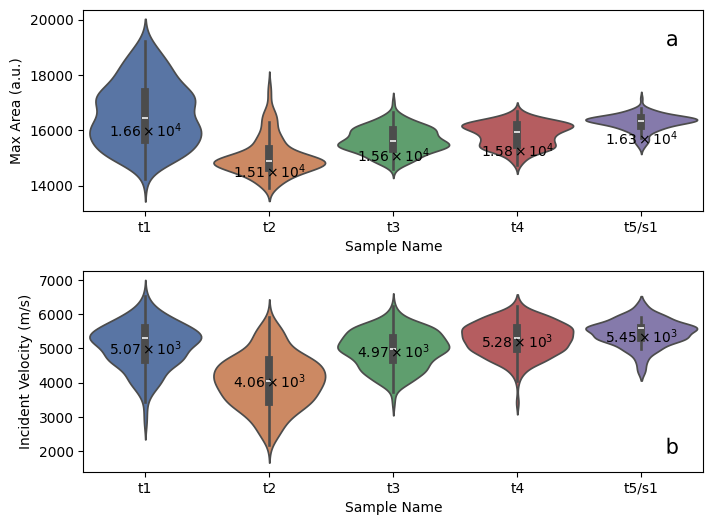

In [ ]:
fig, axes = plot_temporal_violins(df_plume_metrics)
printing.savefig(fig, '5-Plume_metrics_violinplot')
plt.show()

### 2.2 Heatmaps

In [19]:
# analyze the max area
idx = df_frame_metrics.groupby(['Sample Name', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Sample Name', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)

# analyze plume Velocity that can be tracked before landing on the substrate
## calculate the velocity between 2.8cm and 2.9cm for the incident velocity
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 0.028) & (df_frame_metrics['Distance (m)'] <= 0.029)] 
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Sample Name', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Sample Name', 'Plume Index'])
df_plume_metrics.sample(5)

# df_sample
df_sample = df_frame_metrics[(df_frame_metrics['Time (µs)'] >= 0.5) & (df_frame_metrics['Time (µs)'] < 7)] 
df_sample = df_sample[df_sample['Sample Name'].isin(sample_names)]
df_sample = df_sample.dropna()  # Remove all rows with NaN values

../figures/S8-Plume_metrics_temporal_heatmaps.png
../figures/S8-Plume_metrics_temporal_heatmaps.svg
../figures/S8-Plume_metrics_temporal_heatmaps.tif


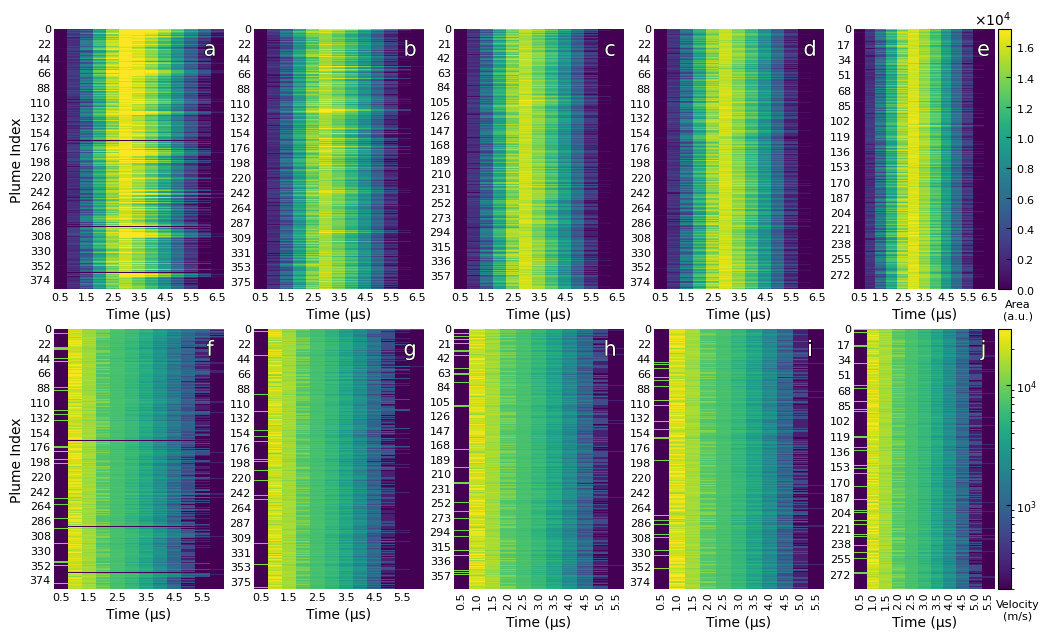

In [25]:
fig, axes_dict = plot_temporal_heatmaps(df_sample, sample_names)
printing.savefig(fig, 'S8-Plume_metrics_temporal_heatmaps')
plt.show()

In [15]:
sample_names

['t1', 't2', 't3', 't4', 't5']

In [ ]:
sample_names
fig, axes_dict = plot_temporal_heatmaps(df_sample, sample_names, custom_palette)
# plt.savefig('../figures/6-Spatial_inhomogeneity_area.svg', dpi=600, bbox_inches='tight', transparent=True)
printing.savefig(fig, '6-Spatial_inhomogeneity_area')
plt.show()